# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Proje Kod Dosyası

* **Grup Adı:** DevTe213
* **Öğrenci:** Muhammed Emin Benzer
* **Model Stratejisi:** Baseline Architecture (Referans Mimari)
* **Açıklama:** Bu notebook, projenin referans noktasını oluşturmak amacıyla tasarlanan en yalın CNN mimarisini içerir. Standart 3x3 konvolüsyon filtreleri ve temel Max Pooling katmanlarından oluşan bu modelin performansı, diğer grup üyelerinin geliştirdiği özelleştirilmiş mimarilerin başarısını ölçmek için bir kıyaslama (benchmark) noktası olarak kullanılacaktır.
**Veri Seti:** Sartaj Bhuvaji (Kaggle) - Brain Tumor Classification (MRI)
    * 4 Sınıf: Glioma, Meningioma, Pituitary, No Tumor

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- ORTAK SEED AYARI ---
SEED = 213
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

Kullanılan Cihaz: cuda


In [7]:
# --- HİPER-PARAMETRELER ---
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 15

# --- VERİ YOLU ---
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-1\training"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
    
    # Train/Val/Test Ayrımı
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Veri Yüklendi. Toplam: {len(full_dataset)}")
    
except Exception as e:
    print(f"HATA: Veri yolu yanlış! {e}")

Veri Yüklendi. Toplam: 2870


In [8]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        
        # --- BLOK 1 ---
        # En standart yapı: 3x3 Kernel, 16 Filtre
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Boyut: 128 -> 64
        
        # --- BLOK 2 ---
        # 16 -> 32 Filtre
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Boyut: 64 -> 32
        
        # --- SINIFLANDIRMA KATMANI ---
        # Flatten sonrası boyut hesabı:
        # Son boyut: 32x32 piksel. Kanal: 32.
        # Toplam nöron: 32 * 32 * 32 = 32768
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 4) # 4 Sınıf

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = self.flatten(x)
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineModel().to(DEVICE)
print("Muhammed Emin Benzer - Baseline Model (Standard CNN) başarıyla oluşturuldu.")

Muhammed Emin Benzer - Baseline Model (Standard CNN) başarıyla oluşturuldu.


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Eğitim Başlıyor... ({EPOCHS} Epoch)")

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100 * val_correct / val_total
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {epoch_train_loss:.4f} - Acc: %{epoch_train_acc:.2f} | Val Acc: %{epoch_val_acc:.2f}")

print("Eğitim Tamamlandı.")

Eğitim Başlıyor... (15 Epoch)
Epoch [1/15] | Train Loss: 1.0838 - Acc: %56.82 | Val Acc: %70.93
Epoch [2/15] | Train Loss: 0.6095 - Acc: %75.30 | Val Acc: %75.12
Epoch [3/15] | Train Loss: 0.4489 - Acc: %83.67 | Val Acc: %80.47
Epoch [4/15] | Train Loss: 0.3169 - Acc: %87.95 | Val Acc: %81.63
Epoch [5/15] | Train Loss: 0.2183 - Acc: %92.58 | Val Acc: %83.49
Epoch [6/15] | Train Loss: 0.1765 - Acc: %93.63 | Val Acc: %83.72
Epoch [7/15] | Train Loss: 0.1196 - Acc: %96.17 | Val Acc: %86.74
Epoch [8/15] | Train Loss: 0.0505 - Acc: %98.80 | Val Acc: %86.98
Epoch [9/15] | Train Loss: 0.0498 - Acc: %98.26 | Val Acc: %87.21
Epoch [10/15] | Train Loss: 0.0223 - Acc: %99.50 | Val Acc: %87.21
Epoch [11/15] | Train Loss: 0.0112 - Acc: %99.90 | Val Acc: %88.14
Epoch [12/15] | Train Loss: 0.0063 - Acc: %99.90 | Val Acc: %87.91
Epoch [13/15] | Train Loss: 0.0034 - Acc: %100.00 | Val Acc: %87.91
Epoch [14/15] | Train Loss: 0.0020 - Acc: %100.00 | Val Acc: %87.44
Epoch [15/15] | Train Loss: 0.0019 - Ac

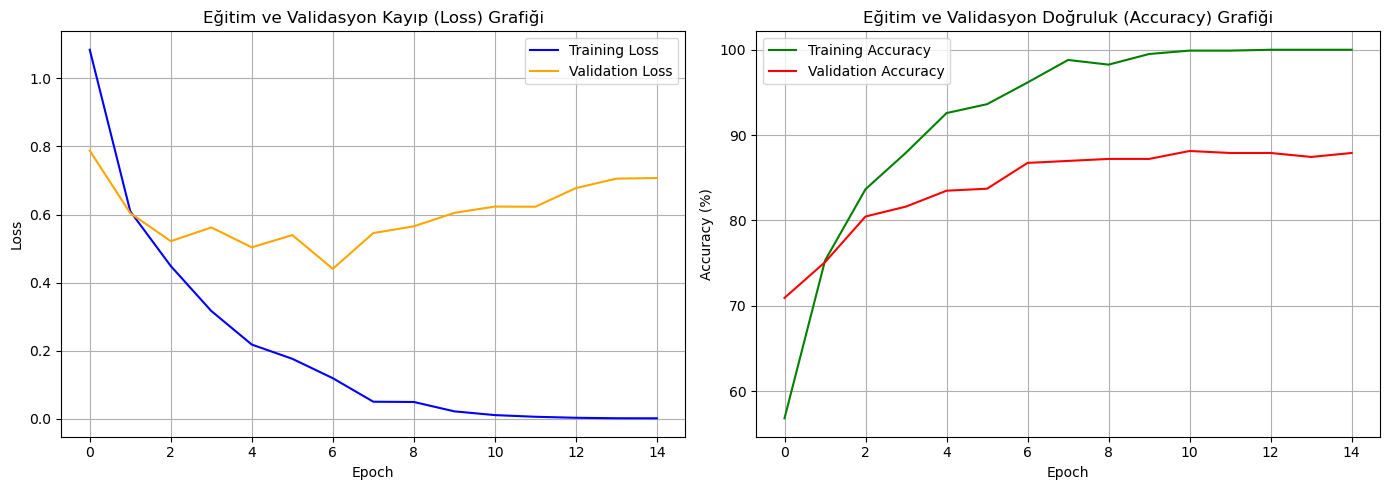

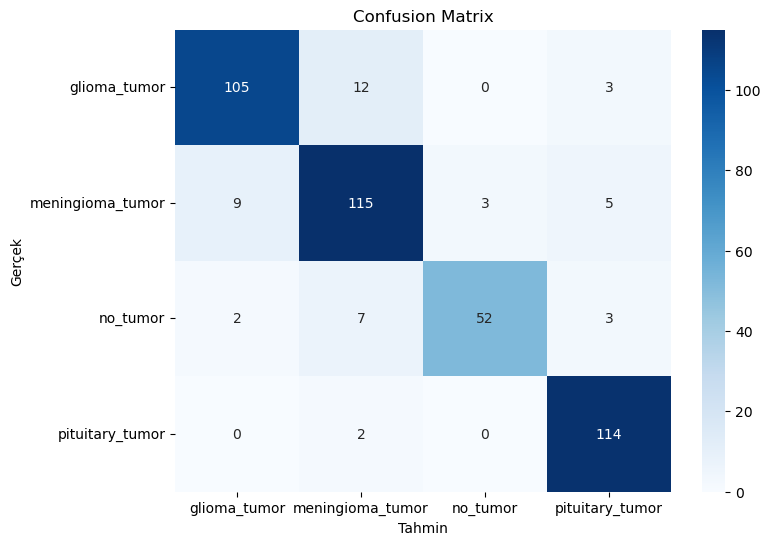


--- SINIFLANDIRMA RAPORU ---

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.88      0.89       120
meningioma_tumor       0.85      0.87      0.86       132
        no_tumor       0.95      0.81      0.87        64
 pituitary_tumor       0.91      0.98      0.95       116

        accuracy                           0.89       432
       macro avg       0.90      0.89      0.89       432
    weighted avg       0.89      0.89      0.89       432



In [11]:
# Grafik Çizimi (Loss ve Accuracy Yan Yana)
plt.figure(figsize=(14, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Eğitim ve Validasyon Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Eğitim ve Validasyon Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TEST VE CONFUSION MATRIX
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

classes = full_dataset.classes
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

print("\n--- SINIFLANDIRMA RAPORU ---\n")
print(classification_report(all_labels, all_preds, target_names=classes))